In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# !pip install pmdarima  #Install it if not installed

In [ ]:
df= pd.read_csv('/content/fisa.csv',index_col='From',parse_dates=True)  #Reading csv as pandas dataframe
df.columns = ['PM10','PM2.5','NO','NO2','NOX','CO','SO2','NH3','O3','C6H6'] # inserting the column name
missing_value_count = df.isnull().sum()  #counting the missing value in csv(df)
print(missing_value_count)
df   #Printing the dataframe

PM10     1681
PM2.5     226
NO       1369
NO2       416
NOX       415
CO        496
SO2      1451
NH3       326
O3        453
C6H6     6195
dtype: int64


,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,O3,C6H6
From,,,,,,,,,,
2023-02-01 00:00:00,95.00,35.00,NaN,90.10,56.20,0.31,NaN,17.70,28.10,0.40
2023-02-01 00:15:00,95.00,35.00,NaN,88.00,55.10,0.33,NaN,18.30,27.10,0.40
2023-02-01 00:30:00,95.00,35.00,NaN,87.70,55.20,0.38,NaN,19.70,24.90,0.40
2023-02-01 00:45:00,122.00,34.00,NaN,88.90,55.70,0.38,NaN,21.30,21.90,0.40
2023-02-01 01:00:00,122.00,34.00,NaN,90.00,55.80,0.38,NaN,22.30,16.70,0.40
...,...,...,...,...,...,...,...,...,...,...
2023-05-01 23:30:00,19.00,11.00,20.80,100.20,70.20,0.58,9.50,10.80,30.00,0.10
2023-05-01 23:45:00,32.00,6.00,21.80,98.80,70.30,NaN,NaN,11.00,33.50,0.10
Min,12.00,3.00,0.10,0.20,4.20,0.10,0.10,4.60,0.10,0.10


In [ ]:
def search_best_arima_parameters(series, p_range, d_range, q_range):   # function to find the best parameters p,d,q of arima model

    best_aic = float("inf")
    best_parameters = None

    # Generate all possible combinations of p, d, q values
    parameter_combinations = list(product(p_range, d_range, q_range))

    for params in parameter_combinations:
        try:
            model = ARIMA(series, order=params)
            model_fit = model.fit()

            # Calculate AIC
            aic = model_fit.aic

            # Update best parameters if AIC is lower
            if aic < best_aic:
                best_aic = aic
                best_parameters = params

        except:
            continue

    return best_parameters, best_aic

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

def impute_missing_values(df):
    for index, value in df['PM2.5'].items():
        if pd.isnull(value):
            index = df.index[df.index.get_loc(index) - 1]
            print("Last non-null index:", index)
            break

    # Plotting subsection of the graph containing missing values
    plt.figure(figsize=[15, 7.5])
    i = df.index[df.index.get_loc(index) + 80]
    j = df.index[df.index.get_loc(index) - 80]
    df.loc[j:i, ['PM2.5', 'PM10', 'NO', 'NO2', 'SO2']].plot()
    plt.title('Concentration with Missing Values')
    plt.ylabel('Concentration')
    plt.xlabel('Date')
    plt.grid(True)

    ad_fuller_result = adfuller(df['PM2.5'][:index])
    print(f'ADF Statistic: {ad_fuller_result[0]}')
    print(f'p-value: {ad_fuller_result[1]}')

    columns_to_fill = ['PM2.5', 'PM10', 'NO', 'NO2', 'SO2']
    for col in columns_to_fill:
        series = df[col][:index]
        best_params, best_aic = search_best_arima_parameters(series, range(0, 6), range(0, 2), range(0, 6))
        print(f"Best ARIMA parameters for {col}:", best_params)
        print(f"AIC for {col}:", best_aic)

        model = ARIMA(df[col][:index], order=best_params)
        model_fit = model.fit()

        i = df.index[df.index.get_loc(index) + 1]
        start_date = i

        while pd.isnull(df.at[i, col]):
            i = df.index[df.index.get_loc(i) + 1]

        end_date = df.index[df.index.get_loc(i) - 1]

        predictions = model_fit.predict(start=start_date, end=end_date, typ='levels').rename('ARIMA Predictions')

        while start_date <= end_date:
            df.at[start_date, col] = predictions[start_date]
            start_date = df.index[df.index.get_loc(start_date) + 1]

    # Plotting the same subsection of the graph with filled values
    plt.figure(figsize=[15, 7.5])
    i = df.index[df.index.get_loc(index) + 80]
    j = df.index[df.index.get_loc(index) - 80]
    df.loc[j:i, ['PM2.5', 'PM10', 'NO', 'NO2', 'SO2']].plot()
    plt.title('Concentration after Filling Missing Values')
    plt.ylabel('Concentration')
    plt.xlabel('Date')
    plt.grid(True)




Last non-null index: 2023-02-04 12:45:00
ADF Statistic: -3.578558883211731
p-value: 0.006184416759621608
Best ARIMA parameters for PM2.5: (4, 1, 4)
AIC for PM2.5: 2810.0963042295534
Best ARIMA parameters for PM10: (4, 1, 4)
AIC for PM10: 3328.2457143787897
Best ARIMA parameters for NO: (0, 1, 0)
AIC for NO: 2.0
Best ARIMA parameters for NO2: (4, 1, 5)
AIC for NO2: 935.4968324489781
Best ARIMA parameters for SO2: (0, 1, 0)
AIC for SO2: 2.0


<Figure size 1500x750 with 0 Axes>

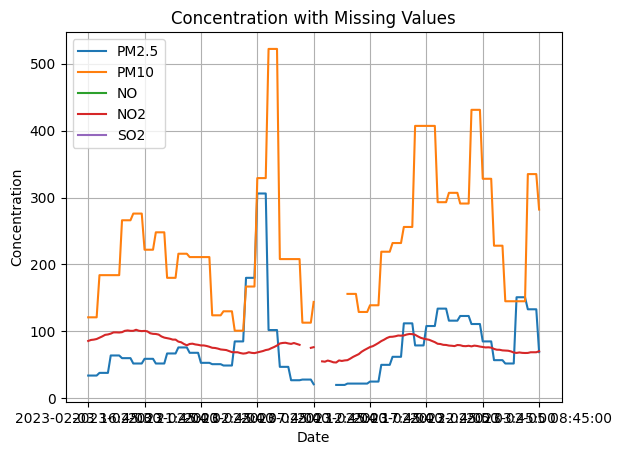

<Figure size 1500x750 with 0 Axes>

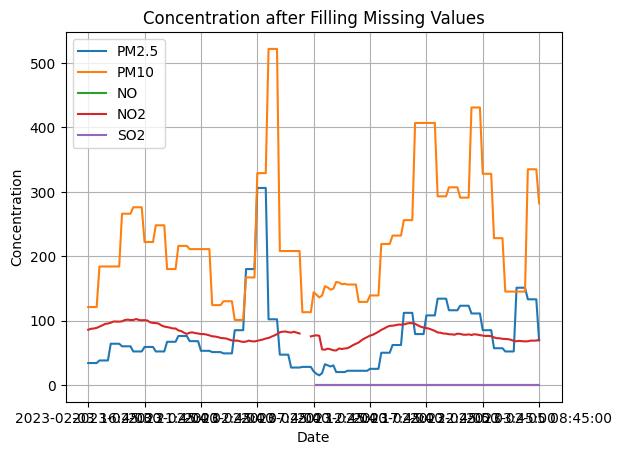

In [ ]:
impute_missing_values(df)

By observing the trend in the values of the parameter 'p' while iterating over different ARIMA models, it is evident that the data is becoming more stationary. This suggests that as we fill in the missing values and include more samples for training the ARIMA model, the data exhibits stronger stationary characteristics.

Among the various ARIMA models tested, the one with the order (4,1,4) demonstrates the best fit to the data. Therefore, we can confidently utilize an ARIMA model of this order to fill in the remaining missing values in the PM2.5 column. This approach eliminates the need to iterate through all possible orders and select the one with the lowest AIC (Akaike Information Criterion).

In summary, based on the decreasing 'p' value and the superior fit of the ARIMA model with an order of (4,1,4), we employ this specific ARIMA model to estimate and fill the missing values in the PM2.5 column.
Similary we use the best parametre obtained from the function to fill the missing values for PM10,NO, NO2, SO2.

In [ ]:
def fill_arima(df, p, d, q):
    for index, value in df['PM2.5'].items():
        if pd.isnull(value):
            index = df.index[df.index.get_loc(index) - 1]
            print("Last non-null index:", index)
            break

    columns_to_fill = ['PM2.5', 'PM10', 'NO', 'NO2', 'SO2']
    for col in columns_to_fill:
        series = df[col][:index]
        model = ARIMA(df[col][:index], order=(p, d, q))
        model_fit = model.fit()

        i = df.index[df.index.get_loc(index) + 1]
        start_date = i

        while pd.isnull(df.at[i, col]):
            i = df.index[df.index.get_loc(i) + 1]

        end_date = df.index[df.index.get_loc(i)]

        predictions = model_fit.predict(start=start_date, end=end_date, typ='levels').rename('ARIMA Predictions')

        while start_date <= end_date:
            df.at[start_date, col] = predictions[start_date]
            start_date = df.index[df.index.get_loc(start_date) + 1]


In [ ]:
fill_arima(df,4,1,4)  ## fillig the arima using the best parametres obtained from the the above function

Last non-null index: 2023-02-05 15:15:00


In [ ]:
while df['PM2.5'].isnull().any():
    fill_arima(df, 4, 1, 4)

Last non-null index: 2023-02-08 14:30:00
Last non-null index: 2023-02-11 15:30:00
Last non-null index: 2023-02-12 16:15:00
Last non-null index: 2023-02-16 10:30:00
Last non-null index: 2023-02-28 23:30:00
Last non-null index: 2023-03-05 00:15:00
Last non-null index: 2023-03-14 16:45:00
Last non-null index: 2023-03-24 00:30:00
Last non-null index: 2023-03-28 18:30:00
Last non-null index: 2023-03-31 23:30:00
Last non-null index: 2023-04-13 08:30:00
Last non-null index: 2023-04-14 00:30:00
Last non-null index: 2023-04-30 12:30:00
Last non-null index: 2023-04-30 14:30:00
Last non-null index: 2023-04-30 23:30:00


In [ ]:
#Column of Benzene(C6H6) is mostly have constant values in bunch hence we are using ffill method to fill missing values of it.
df['C6H6']   = df['C6H6'].ffill()

#On Observing the coumn of,we get the data is varying but the its variation is very less out 22 to 25
#and data is symmetric abhence we can use mean method for filling data.
df['NH3'] = df['NH3'].fillna(df['NH3'].mean())

# Similarly using median method to fill Ozone column
df['O3'] = df['O3'].fillna(df['O3'].median())

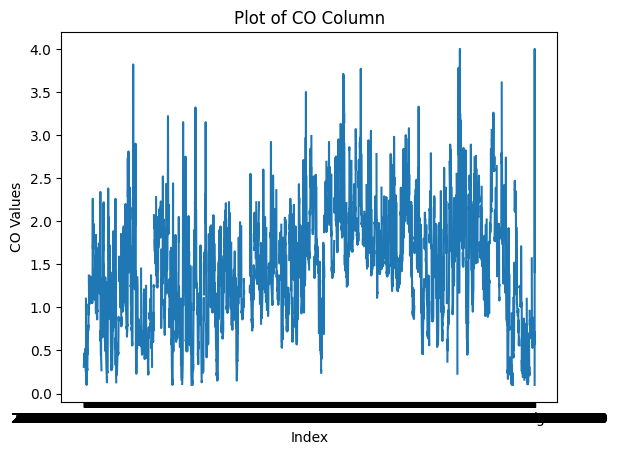

In [ ]:
#CO column is to much linear as we can see in the plot most of the data is in 1 to 2
plt.plot(df['CO'])
plt.xlabel('Index')
plt.ylabel('CO Values')
plt.title('Plot of CO Column')
plt.show()
df['CO'] = df['CO'].interpolate(method = 'linear')  ## filling it
###
df['NOX'] = df['NOX'].interpolate(method = 'linear')


In [ ]:
df.to_csv('filled.csv', index=True, na_rep='NA')
# files.download('filled.csv')

In [ ]:
df= pd.read_csv('filled.csv',index_col='From',parse_dates=True)
df.columns = ['PM10','PM2.5','NO','NO2','NOX','CO','SO2','NH3','O3','C6H6']
null_count = df.isnull().sum()
print(null_count)
df

PM10     625
PM2.5      0
NO       587
NO2      275
NOX        0
CO         0
SO2      666
NH3        0
O3         0
C6H6       0
dtype: int64


,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,O3,C6H6
From,,,,,,,,,,
2023-02-01 00:00:00,95.00,35.00,NaN,90.10,56.20,0.31,NaN,17.70,28.10,0.40
2023-02-01 00:15:00,95.00,35.00,NaN,88.00,55.10,0.33,NaN,18.30,27.10,0.40
2023-02-01 00:30:00,95.00,35.00,NaN,87.70,55.20,0.38,NaN,19.70,24.90,0.40
2023-02-01 00:45:00,122.00,34.00,NaN,88.90,55.70,0.38,NaN,21.30,21.90,0.40
2023-02-01 01:00:00,122.00,34.00,NaN,90.00,55.80,0.38,NaN,22.30,16.70,0.40
...,...,...,...,...,...,...,...,...,...,...
2023-05-01 23:30:00,19.00,11.00,20.80,100.20,70.20,0.58,9.50,10.80,30.00,0.10
2023-05-01 23:45:00,32.00,6.00,21.80,98.80,70.30,0.34,NaN,11.00,33.50,0.10
Min,12.00,3.00,0.10,0.20,4.20,0.10,0.10,4.60,0.10,0.10


You can see count of missing values has decreased .
But still there are some miising values which we can fill using ffill and bfill techniques.

In [ ]:
df = df.ffill()
df = df.bfill()

In [ ]:
df.columns = ['PM10','PM2.5','NO','NO2','NOX','CO','SO2','NH3','O3','C6H6']
null_count = df.isnull().sum()
print(null_count)

PM10     0
PM2.5    0
NO       0
NO2      0
NOX      0
CO       0
SO2      0
NH3      0
O3       0
C6H6     0
dtype: int64


All the missing values has been filled now.

In [ ]:
from google.colab import files
df.to_csv('final_filled.csv', index=True, na_rep='NA')
files.download('final_filled.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<h1><center>Forecasting</center></h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv('final_filled.csv', encoding ='utf-8')
data.head()

,From,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,O3,C6H6
0,2023-02-01 00:00:00,95.0,35.0,0.0,90.1,56.2,0.31,0.0,17.7,28.1,0.4
1,2023-02-01 00:15:00,95.0,35.0,0.0,88.0,55.1,0.33,0.0,18.3,27.1,0.4
2,2023-02-01 00:30:00,95.0,35.0,0.0,87.7,55.2,0.38,0.0,19.7,24.9,0.4
3,2023-02-01 00:45:00,122.0,34.0,0.0,88.9,55.7,0.38,0.0,21.3,21.9,0.4
4,2023-02-01 01:00:00,122.0,34.0,0.0,90.0,55.8,0.38,0.0,22.3,16.7,0.4


In [ ]:
## Checking is there any NULL value or not in the data
data.isnull().sum()

From     0
PM10     0
PM2.5    0
NO       0
NO2      0
NOX      0
CO       0
SO2      0
NH3      0
O3       0
C6H6     0
dtype: int64

Let's Apply forecasting technique on PM10

<Axes: >

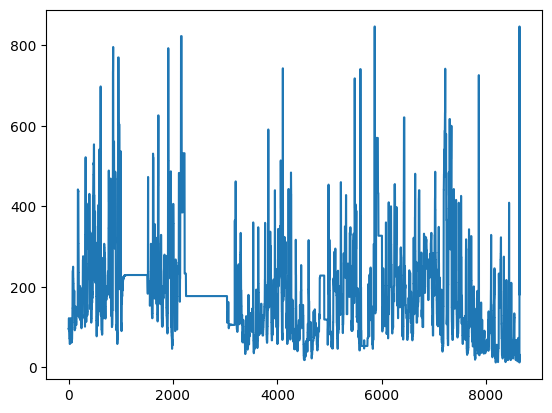

In [ ]:
data['PM10'].plot()

To apply the Model ARMA ARIMA , data should be stationary ,looking at the plot it's tough to say whether it is tationary or not. We can find it by statiscal method . One such popular method is Dickey Fuller Test.

In [ ]:
from statsmodels.tsa.stattools import adfuller
x=data['PM10']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")

ADF Stataics  -9.149134221689351
p-value 2.7164314767783374e-15
critical values 88714.43246978079
fail to reject null hypothese h1 , it mean data is stationary


There are several methods to make dataset stationary one those  is 1st difference method which is very popular, but in our case data is stationary hence we can train the model directly.
We are using the ARIMA Model.

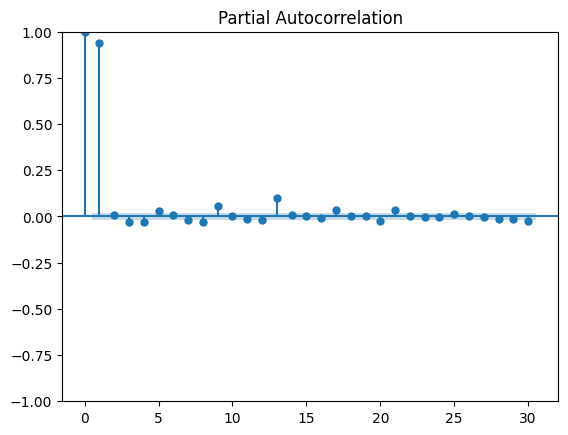

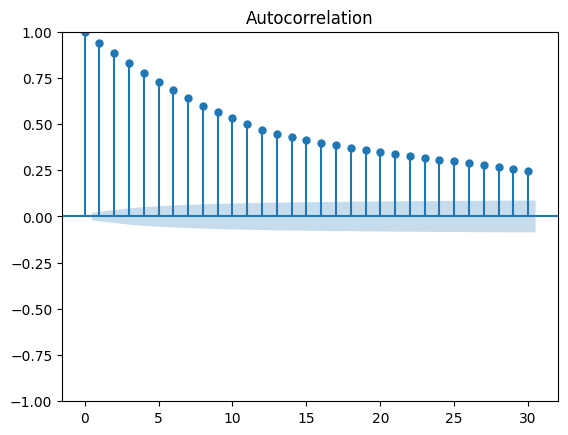

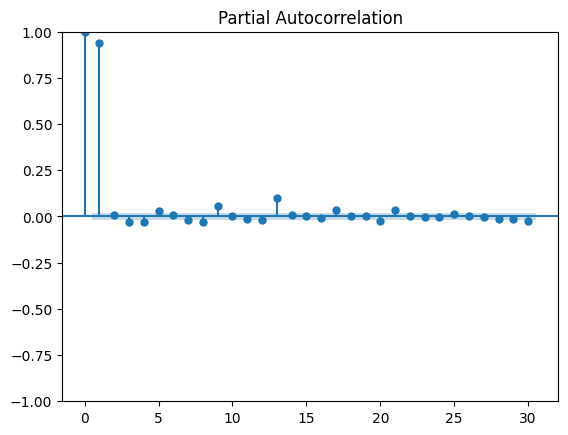

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(data['PM10'].iloc[1:],lags=30)
plot_pacf(data['PM10'].iloc[1:],lags=30)

In [ ]:
# !pip install statsmodels  #install it if you have not installed

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import numpy as np

# Convert date-time column to datetime format
data['From'] = pd.to_datetime(data['From'], format='%d-%m-%Y %H:%M:%S', errors='coerce')

# Define the range of order values to search through
p_values = range(0, 3)  # AR order
d_values = range(0, 2)  # Differencing order
q_values = range(0, 3)  # MA order

# Create a list of all possible combinations of order values
orders = list(product(p_values, d_values, q_values))

# Define a variable to store the best order and its corresponding evaluation metric
best_order = None
best_aic = np.inf  # Initialize with a high value

# Iterate through all combinations and select the order with the lowest AIC
for order in orders:
    try:
        model = ARIMA(data['PM10'], order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_order = order
            best_aic = aic
    except:
        continue

# Print the best order and its corresponding AIC
print("Best Order:", best_order)
print("Best AIC:", best_aic)


Best Order: (2, 1, 2)
Best AIC: 89216.09769356082


We have written the above code to get best order to improve the accuracy of ARIMA Model. We get (2,1,2). which we use in the model and plot it.



<Axes: >

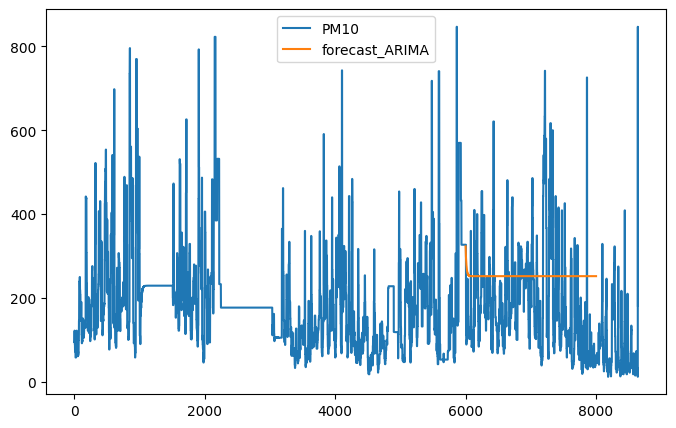

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Convert date-time column to datetime format
data['From'] = pd.to_datetime(data['From'], format='%d-%m-%Y %H:%M:%S', errors = 'coerce')

model = ARIMA(data['PM10'], order=(2, 1, 2))
model_fit = model.fit()
# we are forecasting data from index 6000 to 8000 to check and train our model
data['forecast_ARIMA'] = model_fit.predict(start = 6000, end= 8000, dynamic= True)
data[['PM10', 'forecast_ARIMA']].plot(figsize=(8, 5))

Similary to we can predict the future PM10 values also